epoch = 0      epoch_cost = 2.8396442272044995
epoch = 100      epoch_cost = 1.572129694620768
epoch = 200      epoch_cost = 1.3647403081258143
epoch = 300      epoch_cost = 1.2806140758373117
epoch = 400      epoch_cost = 1.2270775830304184
epoch = 500      epoch_cost = 1.1629544752615468
epoch = 600      epoch_cost = 1.149401057208026
epoch = 700      epoch_cost = 1.1143123273496276
epoch = 800      epoch_cost = 1.1063027381896975
epoch = 900      epoch_cost = 1.082974310274477
epoch = 1000      epoch_cost = 1.0789617467809607
epoch = 1100      epoch_cost = 1.0682659608346443
epoch = 1200      epoch_cost = 1.059850565592448
epoch = 1300      epoch_cost = 1.060023526792173
epoch = 1400      epoch_cost = 1.058218041172734


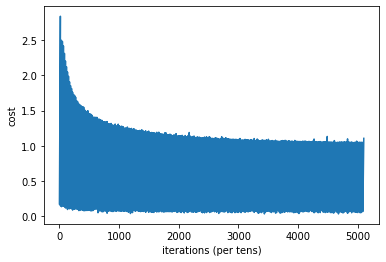

参数已保存到本地pkl文件。
Train Accuracy: 80.93 %
Test Accuracy: 70.00 %


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=8, stride=8, padding=4, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=2, dilation=1, ceil_mode=False)
  )
  (fullconnect): Sequential(
    (0): Linear(in_features=144, out_features=20, bias=True)
    (1): ReLU()
  )
  (classifier): LogSoftmax(dim=1)
)

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from cnn_utils import load_dataset

%matplotlib inline

torch.manual_seed(1)

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

X_train = np.transpose(X_train_orig,(0, 3, 1, 2)) / 255
X_test = np.transpose(X_test_orig,(0, 3, 1, 2)) / 255

Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

def data_loader(X_train, Y_train, batch_size = 64):
    train_id = TensorDataset(torch.from_numpy(X_train).float(), torch.squeeze(torch.from_numpy(Y_train)))
    train_loader = DataLoader(train_id, batch_size = batch_size, shuffle=True)
    
    return train_loader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Conv2d(输入通道数, 输出通道数, kernel_size（长和宽）,stride,padding)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=4,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=8, 
                stride=8,
                padding = 4
            )
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=2, 
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=4, 
                stride=4,
                padding = 2
            )   
        )
        self.fullconnect = nn.Sequential(
            nn.Linear(16 * 3 * 3, 20),
            nn.ReLU()
        )
        self.classifier = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fullconnect(x)
        output = self.classifier(x)
        
        return output

def initialize_paras(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
        
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 1500, batch_size = 64, print_cost = True, is_plot=True):
    train_loader = data_loader(X_train, Y_train, batch_size)
    cnn = CNN()
    
    cost_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate, betas=(0.9, 0.999))
    
    costs = []
    
    m = X_train.shape[0]
    num_batch = m / batch_size
    
    for epoch in range(num_epochs):
        epoch_cost = 0
        
        for step, (batch_x, batch_y) in enumerate(train_loader):
            output = cnn(batch_x)
                
            cost = cost_function(output, batch_y)
            epoch_cost += cost.data.numpy() / num_batch
            
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            if print_cost and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        if epoch % 100 == 0:
            print("epoch = " + str(epoch) + "      epoch_cost = " + str(epoch_cost))
    
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.show()
        
    # 保存学习后的参数
    torch.save(cnn.state_dict(), 'net_params.pkl')
    print('参数已保存到本地pkl文件。')

    #计算训练集预测的结果
    cnn.load_state_dict(torch.load('net_params.pkl'))
    output_train = cnn(torch.from_numpy(X_train).float())
    pred_Y_train = torch.max(output_train, dim=1)[1].data.numpy()
    # 计算测试集预测的结果
    output_test = cnn(torch.from_numpy(X_test).float())
    pred_Y_test = torch.max(output_test, dim=1)[1].data.numpy()
    # 训练集准确率
    print('Train Accuracy: %.2f %%' % float(np.sum(np.squeeze(Y_train) == pred_Y_train)/m*100))
    # 测试集准确率
    print('Test Accuracy: %.2f %%' % float(np.sum(np.squeeze(Y_test) == pred_Y_test)/X_test.shape[0]*100))
    
    
    return cnn
        
model(X_train, Y_train, X_test, Y_test)   
